In [1]:
import sys
sys.path.append(r'../')
import mat73
import numpy as np
from tqdm import tqdm
from scipy import signal
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import matplotlib.animation as animation

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.losses import Loss
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

%reload_ext autoreload
%autoreload 2
from functions import *

2023-07-19 13:41:55.359029: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 13:41:55.446449: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-19 13:41:55.446461: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-19 13:41:55.467354: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-19 13:41:55.933716: W tensorflow/stream_executor/platform/de

In [3]:
data = Database()
X = data.neuron_traces.T
B = data.states

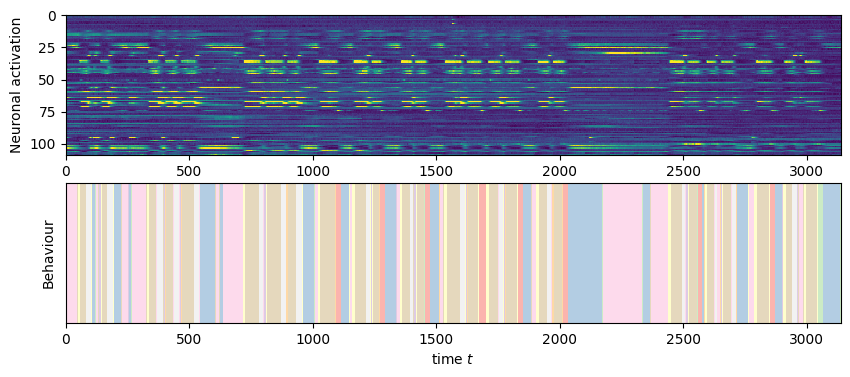

In [4]:
fig, axs = plt.subplots(2,1,figsize=(10,4))
im0 = axs[0].imshow(X.T,aspect='auto', vmax=1, interpolation='None')
axs[0].set_xlabel("time $t$")
axs[0].set_ylabel("Neuronal activation")
im1 = axs[1].imshow([B],aspect='auto', cmap="Pastel1")
#cbar1 = plt.colorbar(im1, ticks=np.arange(8))
#cbar1.ax.set_yticklabels(['Dorsal turn', 'Forward', 'No state', 'Reverse-1', 'Reverse-2', 'Sustained reverse', 'Slowing', 'Ventral turn']) 
plt.xlabel("time $t$")
plt.ylabel("Behaviour")
plt.yticks([])
plt.axis([0,X.shape[0],-0.5,0.5])
plt.savefig('Figures/worm_data.svg')

## Preprocessing the data

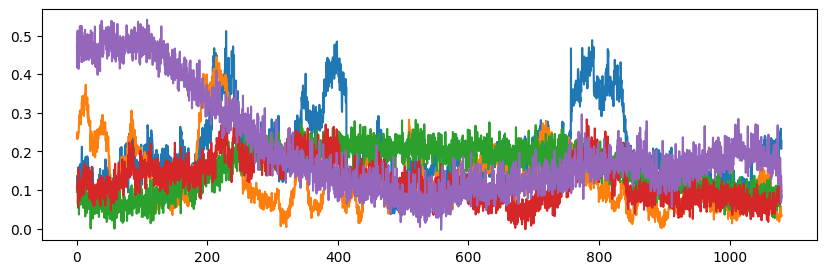

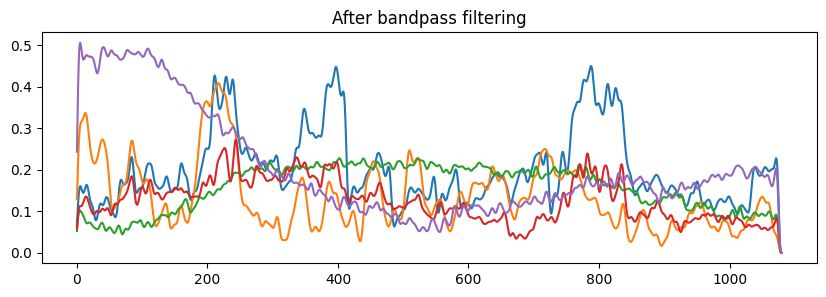

In [5]:
time = 1/data.fps*np.arange(0,X.shape[0])
filtered = bandpass(X.T, f_l=1e-10, f_h=0.072, sampling_freq=float(data.fps)).T

nn = np.arange(80,85)
plt.figure(figsize = [10,3])
plt.plot(time, X[:,nn])
plt.figure(figsize = [10,3])
plt.plot(time, filtered[:,nn])
plt.title('After bandpass filtering')
plt.show()

X = filtered

### Preparing the data  

In [6]:
# Preparing the data (Method new)
win = 1
win += 1
gap = 1
X_win = np.zeros((X.shape[0]-win-gap, win, X.shape[1]))

for i, _ in enumerate(X_win):
    X_win[i] = X[i:i+win]

Xwin0, Xwin1 = X_win[:,:-1,:], X_win[:,1:,:]
B_1 = B[1:]
X_paired = np.array([Xwin0, Xwin1])
X_paired = np.transpose(X_paired, axes=(1,0,2,3))

# Train test split 
kf = KFold(n_splits=7)
for i, (train_index, test_index) in enumerate(kf.split(X_win)):
    if i==4: 
        # Train test split based on a fold
        X_train, X_test = X_paired[train_index], X_paired[test_index]
        B_train_1, B_test_1 = B_1[train_index], B_1[test_index]        

### Calculating participation ratio


Participation ratio:  3.513


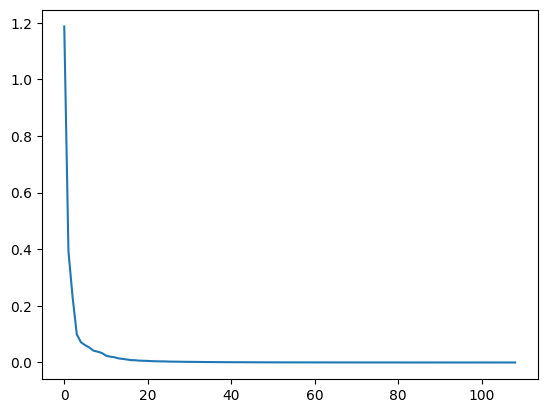

In [7]:
cov = np.cov(X_train[:,0,0,:].T)
eigvals, eigvecs = np.linalg.eig(cov)
plt.plot(eigvals)
PR = (np.sum(eigvals)**2) / (np.sum(eigvals**2))
print('Participation ratio: ', PR.round(3))

## PCA

In [8]:
dim = 3
pca = PCA(n_components=dim)
pca.fit(X_train[:,0,0,:])
print('Percentage of variance explained by the first ', dim, ' PCs: ', pca.explained_variance_ratio_[:dim].sum().round(3))

Percentage of variance explained by the first  3  PCs:  0.753


#### Projecting into latent space

In [9]:
Y0_tr = pca.transform(X_train[:,0,0,:])
Y1_tr = pca.transform(X_train[:,1,0,:])
Ydiff_tr = Y1_tr - Y0_tr

Y0_tst = pca.transform(X_test[:,0,0,:])
Y1_tst = pca.transform(X_test[:,1,0,:])
Ydiff_tst = Y1_tst - Y0_tst

np.savetxt('Saved_Y/Y0_tr__PCA.csv',Y0_tr)
np.savetxt('Saved_Y/Y1_tr__PCA.csv',Y1_tr)
np.savetxt('Saved_Y/Y0_tst__PCA.csv',Y0_tst)
np.savetxt('Saved_Y/Y1_tst__PCA.csv',Y1_tst)
np.savetxt('Saved_Y/B_train_1__PCA.csv',B_train_1)
np.savetxt('Saved_Y/B_test_1__PCA.csv',B_test_1)

#### Plotting first 3 PCs


(0.0, 2686.0, -0.5, 0.5)

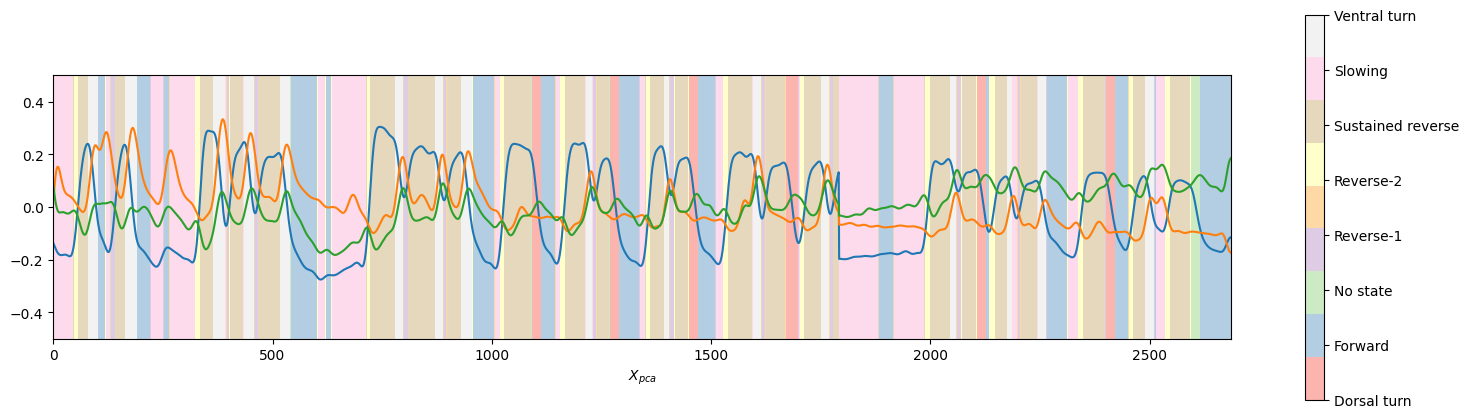

In [10]:
%matplotlib inline
plt.figure(figsize=(19,5))
plt.imshow([B_train_1],aspect=600,cmap="Pastel1")
cbar = plt.colorbar(ticks=np.arange(8))
cbar.ax.set_yticklabels(['Dorsal turn', 'Forward', 'No state', 'Reverse-1', 'Reverse-2', 'Sustained reverse', 'Slowing', 'Ventral turn']) 
plt.plot(Y0_tr/Y0_tr.max()/3)
plt.xlabel("time $t$")
plt.xlabel("$X_{pca}$")
plt.axis([0,Y0_tr.shape[0],-0.5,0.5])


<IPython.core.display.Javascript object>


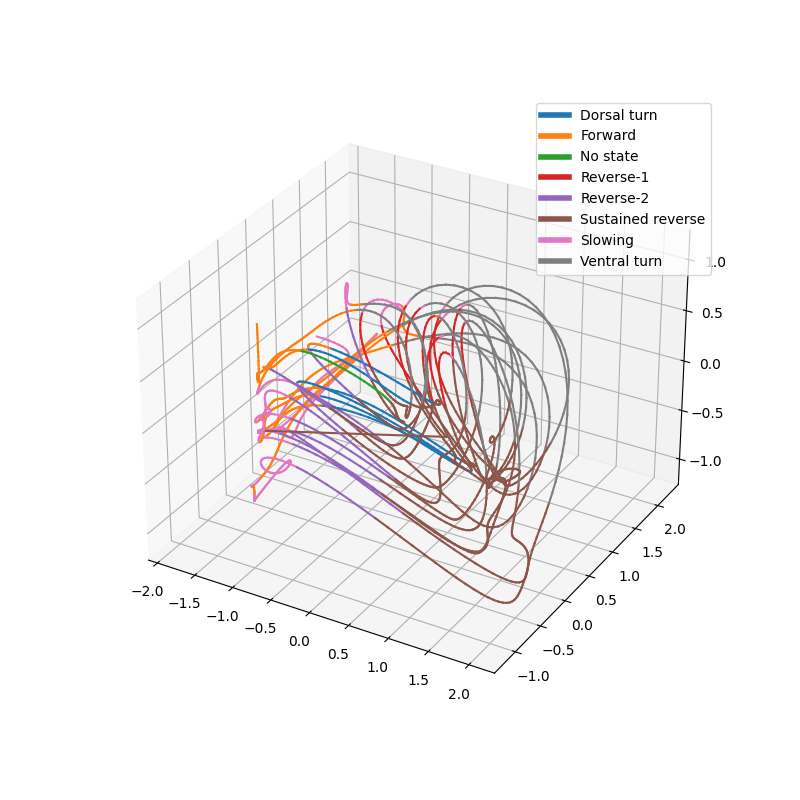

<Axes3DSubplot: >

In [11]:
%matplotlib notebook
plot_phase_space(Y0_tr, B_train_1)

In [11]:
### Run to produce rotating 3-D plot
#%matplotlib notebook    
#rotating_plot(Y0_tr, B_train_1)

### Behaviour predictor


2022-11-02 14:44:16.804136: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 14:44:16.804455: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-02 14:44:16.804518: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-11-02 14:44:16.804573: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-11-02 14:44:16.804624: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

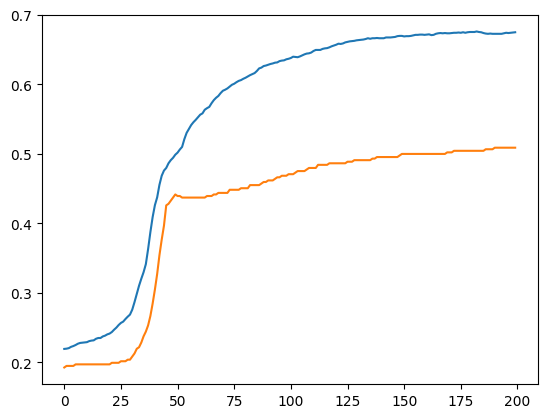

In [11]:
%matplotlib inline
b_predictor = tf.keras.Sequential([
#    layers.Dense(80, activation='relu'),
#    layers.Dense(20, activation='relu'),
    layers.Dense(8, activation='linear')
]) 
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

b_predictor.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = b_predictor.fit(Y1_tr,
                      B_train_1,
                      epochs=200,
                      batch_size=500,
                      validation_data=(Y1_tst, B_test_1),
                      verbose=0
                      )

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [14]:
B1_pred = b_predictor(Y1_tst).numpy().argmax(axis=1)
accuracy_score(B1_pred, B_test_1)

0.5089686098654709

### Autoregressor: Predicting $Y_{t+1}$ from $Y_t$

On training set 

Baseline mse 0.00116 Model mse: 0.00094

On test set 

Baseline mse 0.00058 Model mse: 0.00067
On training set 

Baseline mse 0.00116 Model mse: 0.00094

On test set 

Baseline mse 0.00058 Model mse: 0.00061
On training set 

Baseline mse 0.00116 Model mse: 0.00094

On test set 

Baseline mse 0.00058 Model mse: 0.00064
On training set 

Baseline mse 0.00116 Model mse: 0.00094

On test set 

Baseline mse 0.00058 Model mse: 0.00063
On training set 

Baseline mse 0.00116 Model mse: 0.00094

On test set 

Baseline mse 0.00058 Model mse: 0.00062
On training set 

Baseline mse 0.00116 Model mse: 0.00094

On test set 

Baseline mse 0.00058 Model mse: 0.00065
On training set 

Baseline mse 0.00116 Model mse: 0.00094

On test set 

Baseline mse 0.00058 Model mse: 0.00063
On training set 

Baseline mse 0.00116 Model mse: 0.00094

On test set 

Baseline mse 0.00058 Model mse: 0.00063
On training set 

Baseline mse 0.00116 Model mse: 0.00094

On test set 

Baseline mse 0.00058 Mo

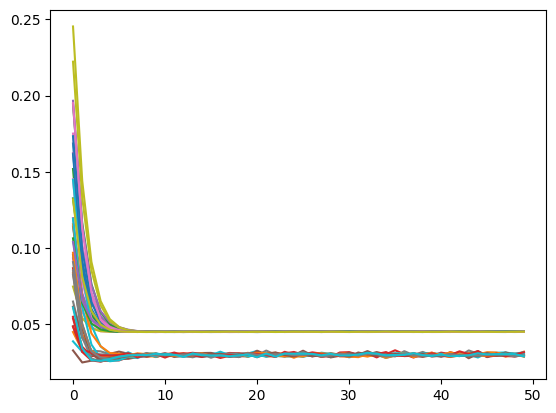

In [15]:
%matplotlib inline
mse_list = []
for i in range(20):
    ### Scaling input and output data
    Yinmax = (np.abs(Y0_tr)).max() # Parameters for scaling
    Y0_tr, Y0_tst = Y0_tr/Yinmax, Y0_tst/Yinmax
    Ydmax = (np.abs(Ydiff_tr)).max() # Parameters for scaling
    Ydiff_tr, Ydiff_tst = Ydiff_tr/Ydmax, Ydiff_tst/Ydmax

    # Defining the model
    model_ydiff_f_yt = tf.keras.Sequential([
        #tf.keras.layers.Dense(3, activation='relu'),
        #tf.keras.layers.Dense(5, activation='relu'),
        #tf.keras.layers.Dense(7, activation='relu'),
        #tf.keras.layers.Dense(10, activation='relu'),
        #tf.keras.layers.Dense(7, activation='relu'),
        #tf.keras.layers.Dense(5, activation='relu'),
        tf.keras.layers.Dense(3, activation='linear')
    ])
    opt = tf.keras.optimizers.Adam(learning_rate=0.01)

    model_ydiff_f_yt.compile(optimizer=opt,
                  loss='mse',
                  metrics=['mse'])


    history = model_ydiff_f_yt.fit(Y0_tr,
                          Ydiff_tr,
                          epochs=50,
                          batch_size=100,
                          validation_data=(Y0_tst, Ydiff_tst),
                          verbose=0
                          )
    # Summarize history for accuracy
    plt.plot(history.history['mse'])
    plt.plot(history.history['val_mse'])

    # Preidctions
    Ydiff_tr_pred = model_ydiff_f_yt(Y0_tr).numpy()
    Ydiff_tst_pred = model_ydiff_f_yt(Y0_tst).numpy()

    # Inverse scaling the data
    Ydiff_tr_pred, Ydiff_tr, Y0_tr = Ydiff_tr_pred*Ydmax, Ydiff_tr*Ydmax, Y0_tr*Yinmax
    Ydiff_tst_pred, Ydiff_tst, Y0_tst = Ydiff_tst_pred*Ydmax, Ydiff_tst*Ydmax, Y0_tst*Yinmax

    Y1_tr_pred = Y0_tr + Ydiff_tr_pred
    Y1_tst_pred = Y0_tst + Ydiff_tst_pred

    # Evaluation
    baseline_tr  = mean_squared_error(flat_partial(Y1_tr), flat_partial(Y0_tr))
    modelmse_tr = mean_squared_error(flat_partial(Y1_tr), flat_partial(Y1_tr_pred))
    baseline_tst  = mean_squared_error(flat_partial(Y1_tst), flat_partial(Y0_tst))
    modelmse_tst = mean_squared_error(flat_partial(Y1_tst), flat_partial(Y1_tst_pred))
    
    print('On training set \n')
    print('Baseline mse', baseline_tr.round(5), 'Model mse:', modelmse_tr.round(5))
    print('\nOn test set \n')
    print('Baseline mse', baseline_tst.round(5), 'Model mse:', modelmse_tst.round(5))
    
    mse_list.append([baseline_tr, modelmse_tr, baseline_tst, modelmse_tst])

In [16]:
print(np.mean(mse_list, axis=0))
print(np.std(mse_list, axis=0))

[0.00116052 0.00094188 0.00057644 0.00063208]
[4.33680869e-19 1.74165423e-06 0.00000000e+00 1.94365001e-05]


#### Autoregression: with linear regression 
(deterministic as opposed to probabilistic neural net's solution)

In [17]:
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression()
linear_reg.fit(Y0_tr, Ydiff_tr)

Ydiff_tr_pred = linear_reg.predict(Y0_tr)
Ydiff_tst_pred = linear_reg.predict(Y0_tst)

Y1_tr_pred = Y0_tr + Ydiff_tr_pred
Y1_tst_pred = Y0_tst + Ydiff_tst_pred

# Evaluation
baseline_tr  = mean_squared_error(flat_partial(Y1_tr), flat_partial(Y0_tr))
modelmse_tr = mean_squared_error(flat_partial(Y1_tr), flat_partial(Y1_tr_pred))
baseline_tst  = mean_squared_error(flat_partial(Y1_tst), flat_partial(Y0_tst))
modelmse_tst = mean_squared_error(flat_partial(Y1_tst), flat_partial(Y1_tst_pred))

print('On training set \n')
print('Baseline mse', baseline_tr.round(5), 'Model mse:', modelmse_tr.round(5))
print('\nOn test set \n')
print('Baseline mse', baseline_tst.round(5), 'Model mse:', modelmse_tst.round(5))

print('\nGoodness of autoregressor:', 1 - modelmse_tst/baseline_tst)

On training set 

Baseline mse 0.00116 Model mse: 0.00094

On test set 

Baseline mse 0.00058 Model mse: 0.00063

Goodness of autoregressor: -0.08857230610156908


In [18]:
hits_at_rank(5,Y1_tr, Y1_tr_pred)

0.8096484667165296